In [1]:
# create and evaluate an updated autoregressive model
from tqdm import tqdm_notebook
import os
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from scipy.signal import savgol_filter
# load dataset
csv_dir = "../csv/"
splittedByCountry_dir  = csv_dir + "splittedByCountry/"
predictedResultAutoReg_dir = csv_dir + "prediction/"

# **Finding Best Window Size for each file**

In [2]:
window_size = {}

for file in tqdm_notebook(os.listdir(splittedByCountry_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "Cases_on_an_international_conveyance_Japan.csv":
        continue
    series = read_csv(splittedByCountry_dir + file, header=0, index_col=0, parse_dates=True, squeeze=True)[['cases']]
    series = series['20200701':]

    # split dataset
    X = series.values
    X = X.flatten()
    X = savgol_filter(X, 51, 3).reshape(-1, 1)
    train, test = X[1:len(X)-7], X[len(X)-7:]

    rmse = 10*10
    window_size[file] = 40

    for window in range(5, 40):
        # train autoregression
        model = AutoReg(train, lags=window, old_names=False)
        model_fit = model.fit()
        coef = model_fit.params
        # walk forward over time steps in test
        history = train[len(train)-window:]
        history = [history[i] for i in range(len(history))]
        predictions = list()
        for t in range(len(test)):
            length = len(history)
            lag = [history[i] for i in range(length-window,length)]
            yhat = coef[0]
            for d in range(window):
                yhat += coef[d+1] * lag[window-d-1]
            obs = test[t]
            predictions.append(yhat)
            history.append(yhat)

        if rmse > sqrt(mean_squared_error(test, predictions)):
            rmse = sqrt(mean_squared_error(test, predictions))
            window_size[file] = window

# **Testing Model**

Test MAPE: 29.797


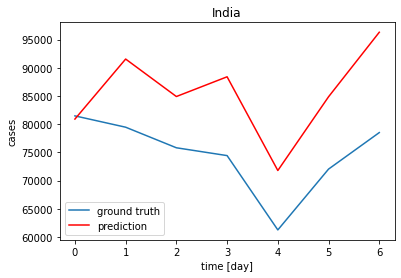

Test MAPE: 23.280


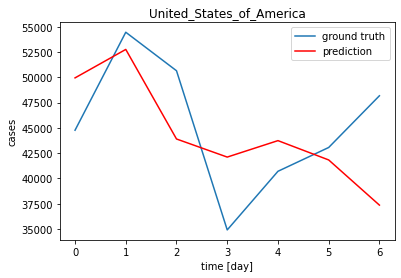

Test MAPE: 31.059


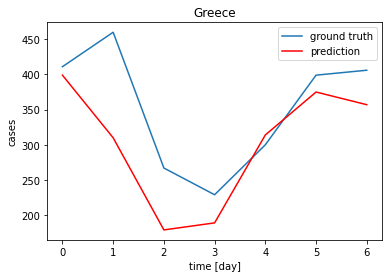

Test MAPE: 18.154


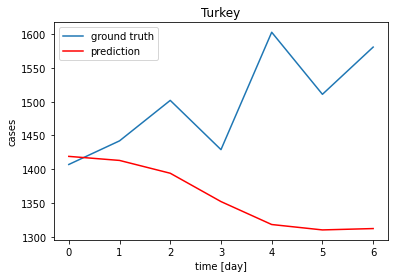

Test MAPE: 23.288


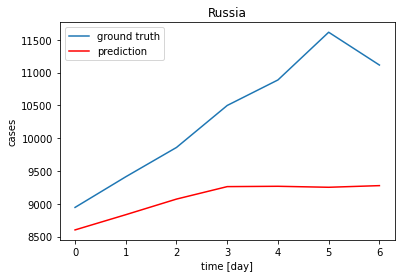

In [4]:
for file in tqdm_notebook(os.listdir(splittedByCountry_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "Cases_on_an_international_conveyance_Japan.csv":
        continue

    if file[:-4] not in ['Russia', 'Greece', 'India', 'United_States_of_America', 'Turkey']:
        continue

    series = read_csv(splittedByCountry_dir + file, header=0, index_col=0, parse_dates=True, squeeze=True)[['cases']]

    # split dataset
    X = series.values
    train, test = X[1:len(X)-7], X[len(X)-7:]

    window = window_size[file]
    # train autoregression
    model = AutoReg(train, lags=window, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(yhat)
        # print('predicted=%f, expected=%f' % (yhat, obs))

    ReLU = lambda a: (a > 0) * a
    predictions = np.asarray(predictions)
    predictions = ReLU(predictions)
    predictions = np.rint(predictions)
    predictions = np.abs(predictions)

    MAPE = lambda a, f: 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a))*100)


    rmse = sqrt(mean_squared_error(test, predictions))
    mape = MAPE(test, predictions)

    print('Test MAPE: %.3f' % mape)

    # plot
    # pyplot.plot(test)
    # pyplot.plot(predictions, color='red')
    # pyplot.title(file[:-4])
    # pyplot.xlabel('time [day]')
    # pyplot.ylabel('cases')
    # pyplot.legend(['ground truth', 'prediction'])
    # pyplot.show()

# **Predicting Future Seven Days**

In [6]:
outputs = {}

for file in tqdm_notebook(os.listdir(splittedByCountry_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "Cases_on_an_international_conveyance_Japan.csv":
        continue
    series = read_csv(splittedByCountry_dir + file, header=0, index_col=0, parse_dates=True, squeeze=True)[['cases']]

    # split dataset
    X = series.values

    window = window_size[file]
    # train autoregression
    model = AutoReg(X, lags=window, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = X[len(X)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(7):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(yhat)

    ReLU = lambda a: (a > 0) * a
    predictions = np.asarray(predictions)
    predictions = ReLU(predictions)
    predictions = np.rint(predictions)
    predictions = np.abs(predictions)

    outputs[file[:-4]] = predictions.flatten()

In [7]:
df = pd.DataFrame(data=outputs)
df['Cases_on_an_international_conveyance_Japan'] = [0, 0, 0, 0, 0, 0, 0]
df = df.reindex(sorted(df.columns), axis=1)
df.index = ['10/9', '10/10', '10/11', '10/12', '10/13', '10/14', '10/15'] 
df.to_csv(predictedResultAutoReg_dir + 'prediction.csv')
print(df)

       Afghanistan  Albania  Algeria  Andorra  Angola  Anguilla  \
10/9          55.0    158.0    124.0     24.0   223.0       0.0   
10/10         98.0    159.0    121.0     99.0    43.0       0.0   
10/11        118.0    158.0    118.0     70.0   237.0       0.0   
10/12         79.0    158.0    115.0      0.0    71.0       0.0   
10/13         84.0    159.0    113.0    305.0   214.0       0.0   
10/14        104.0    159.0    111.0      0.0    74.0       0.0   
10/15         92.0    160.0    110.0    260.0   205.0       0.0   

       Antigua_and_Barbuda  Argentina  Armenia  Aruba  ...  \
10/9                   1.0    17292.0    646.0   15.0  ...   
10/10                  1.0    15295.0    679.0   15.0  ...   
10/11                  1.0    13409.0    672.0   14.0  ...   
10/12                  1.0    10814.0    625.0    4.0  ...   
10/13                  1.0    11140.0    375.0    0.0  ...   
10/14                  1.0    14027.0    528.0    7.0  ...   
10/15                  1.0   